# Gesture Recognition

**Problem Statement** 
- To develop a classifier that can accuretly classify the gestures
- There are five gesture classes:
    - Thumbs up:  Increase the volume
    - Thumbs down: Decrease the volume
    - Left swipe: 'Jump' backwards 10 seconds
    - Right swipe: 'Jump' forward 10 seconds  
    - Stop: Pause the movie
- Each video is a sequence of 30 frames 

## Importing the required libraries

In [ ]:
# !pip install scipy==1.1.0

**scipy=1.1.0 is not compatiable with python 3.9+**

**Cannot install scipy-1.1.0**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import 
import cv2
# from scipy.misc import imread, imresize
import datetime
import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers, losses, metrics, regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3

***`imread` and `imresize` are depricated in latest version of scipy, hence using OpenCV for image pre-processing***

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
## Checking the available GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
## Reading the training and validation data file

train_doc = np.random.permutation(open('D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/val.csv').readlines())

print("Train data size - {} sequences".format(len(train_doc)))
print("Validation data size - {} sequences".format(len(val_doc)))

Train data size - 663 sequences
Validation data size - 100 sequences


## Generator function

In [5]:
## Helper function for scaling
def scale_img(image, ch):
    image = (image[:,:, ch] - np.min(image[:,:,ch]))/(np.max(image[:,:,ch]) - np.min(image[:,:,ch]))
    return image

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.linspace(4, 28, num_frames).astype(int)
    
    ## Complete Batches
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t)//batch_size # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,len(img_idx),h,w, num_ch)) 
            batch_labels = np.zeros((batch_size,num_cls)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                
                
                for idx, item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    # reading the image
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    # converting the image from BRG to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # resizing the image to (120x120)
                    image = cv2.resize(image, (h, w), interpolation = cv2.INTER_CUBIC)
                    
                    batch_data[folder,idx,:,:,0] = scale_img(image, 0)
                    batch_data[folder,idx,:,:,1] = scale_img(image, 1)
                    batch_data[folder,idx,:,:,2] = scale_img(image, 2)
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        
        
        # code for the remaining data points which are left after full batches
        if(len(folder_list)%batch_size!=0):
            batch_size = int(len(folder_list)%batch_size)
            
#             t = np.random.permutation(folder_list)
            batch_data = np.zeros((batch_size,len(img_idx),h,w, num_ch)) 
            batch_labels = np.zeros((batch_size,num_cls)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_size)].split(';')[0])

                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + batch_size].strip().split(';')[0]+'/'+imgs[item])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (h, w), interpolation = cv2.INTER_CUBIC)

                    batch_data[folder,idx,:,:,0] = scale_img(image, 0)
                    batch_data[folder,idx,:,:,1] = scale_img(image, 1)
                    batch_data[folder,idx,:,:,2] = scale_img(image, 2)

                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels

- Image Cropping not performed as some of the images have some features at extreem right or left positions
- Only images are resized to 120x120 as 120 is the least dimension the data

In [7]:
### model parameters 

h = 120
w = 120
num_ch = 3
num_cls = 5
num_frames = 15
# image_ind = np.linspace(4, 28, num_frames).astype(int)
# batch_size = 64
# batch_size =  32
batch_size =  16

curr_dt_time = datetime.datetime.now()

## Data paths
train_path = 'D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train'
val_path = 'D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/val'

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [8]:
## Initializing the sample generator objects
sample_generator = generator(train_path, train_doc, batch_size)

## Verifying the generator output
sample_data, sample_label = next(sample_generator)
print(sample_data.shape, sample_label.shape)

Source path =  D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train ; batch size = 16
(16, 15, 120, 120, 3) (16, 5)


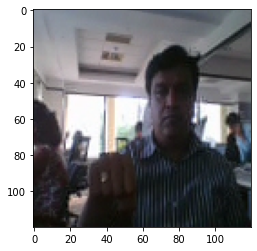

In [9]:
## sample data
plt.imshow(sample_data[1, 1]);

In [10]:
## Sample label
sample_label

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
## Initializing the train and validation data genertor

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
## Helper functiont to plot the model performance - loss and accuracy

def plot_performance(history):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", round(max(history.history['categorical_accuracy']), 3))
    print("Max. Validaiton Accuracy", round(max(history.history['val_categorical_accuracy']), 3))

In [13]:
## Define Callbacks

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, cooldown=0, verbose=1)
callbacks_list = [checkpoint, LR]

In [14]:
## traing steps per epochs and validation steps

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model

Employed 2 modeling approaches 
- Using 3D Convolution model
- 2D Convolution with a RNN model

### 3D Convolution Model
- Multiple model configration are experimented and recoded in the writeup file
- Only the final run is can be seen here

In [13]:
## Conv3D model

filters = [16, 32, 64, 128]
kernel_size = [(2, 2, 2), (3, 3, 3), (5, 5, 5), (7, 7, 7)]
num_frames = 15
input_shape = (num_frames, h, w, num_ch)

model = Sequential()

model.add(Conv3D(filters[0], kernel_size=kernel_size[2], input_shape = input_shape, padding='same', activation='relu'))
# model.add(Conv3D(filters[0], kernel_size=kernel_size[2], padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters[1], kernel_size=kernel_size[2], padding='same', activation='relu'))
# model.add(Conv3D(filters[1], kernel_size=kernel_size[2], padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu'))
# model.add(Conv3D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

# model.add(Conv3D(filters[3], kernel_size=kernel_size[2], input_shape = input_shape, padding='same', activation='relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(BatchNormalization())

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(num_cls, activation='softmax'))

optimiser = optimizers.Adam()
# optimiser = optimizers.SGD(learning_rate=0.01)

## Compiling the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 120, 16)  6016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 60, 60, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 60, 60, 32)     64032     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 30, 30, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 30, 30, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 30, 30, 64)     2

In [17]:
%%time
## Training
num_epochs = 50
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - 39s 2s/step - loss: 3.6955 - categorical_accuracy: 0.4434 - val_loss: 47.8144 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 47.81443, saving model to model_init_2022-07-1200_07_36.811172\model-00001-3.69550-0.44344-47.81443-0.17000.h5
Epoch 2/50
11/11 [==============================] - 10s 1s/step - loss: 1.7095 - categorical_accuracy: 0.5810 - val_loss: 60.1605 - val_categorical_accuracy: 0.1562

Epoch 00002: val_loss did not improve from 47.81443
Epoch 3/50
11/11 [==============================] - 9s 842ms/step - loss: 2.0668 - categorical_accuracy: 0.5534 - val_loss: 7.6688 - val_categorical_accuracy: 0.2143

Epoch 00003: val_loss improved from 47.81443 to 7.66880, saving model to model_init_2022-07-1200_07_36.811172\model-00003-2.06678-0.55336-7.66880-0.21429.h5
Epoch 4/50
11/11 [==========

11/11 [==============================] - 5s 516ms/step - loss: 0.1141 - categorical_accuracy: 0.9572 - val_loss: 4.3441 - val_categorical_accuracy: 0.7500

Epoch 00032: val_loss did not improve from 0.18385
Epoch 33/50
11/11 [==============================] - 6s 537ms/step - loss: 0.1134 - categorical_accuracy: 0.9626 - val_loss: 0.5739 - val_categorical_accuracy: 0.7500

Epoch 00033: val_loss did not improve from 0.18385
Epoch 34/50
11/11 [==============================] - 5s 496ms/step - loss: 0.1165 - categorical_accuracy: 0.9572 - val_loss: 3.7901 - val_categorical_accuracy: 0.3750

Epoch 00034: val_loss did not improve from 0.18385

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 35/50
11/11 [==============================] - 5s 512ms/step - loss: 0.1382 - categorical_accuracy: 0.9412 - val_loss: 0.2910 - val_categorical_accuracy: 0.8750

Epoch 00035: val_loss did not improve from 0.18385
Epoch 36/50
11/11 [==============================] - 5

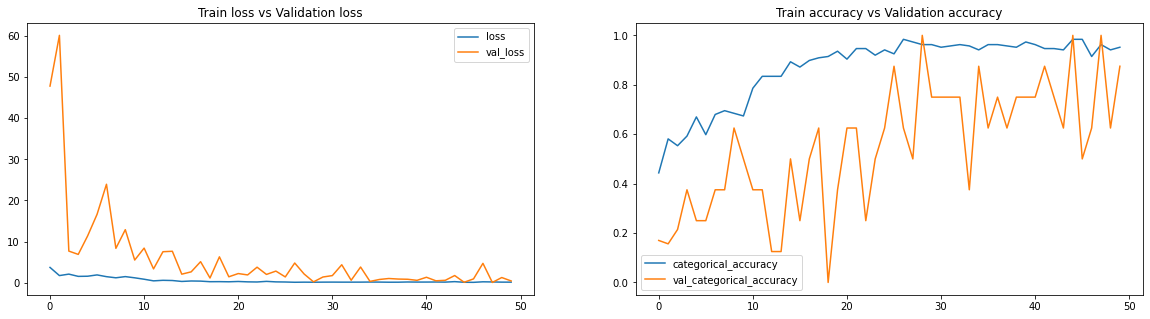

Max. Training Accuracy 0.984
Max. Validaiton Accuracy 1.0


In [18]:
plot_performance(history)

**Observation**
- Conducted multiple experimentations by modifying the network architecture and model parameters like - Batch_size, kernal_size, learning_rate, optimization_function, droput_values and so on.
- Following experiments performed
    - n/w architecture
        - 4x (Conv3D+BN+Pooling) + 2FC
        - 3x (Conv3D+BN+Pooling) + 2FC
        - 3x (2xConv3D+BN+pooling) + 2FC
    - number of frames considered - 10/15/18/20
    - Batch_size - 16/32/64
    - epochs - 20/30/50
    - fiter_size - (2,2,2)/(3,3,3)/(5,5,5)
    - LR - 0.001/0.0005
    - Optimizer ADAM/SGD

- Model overfits in few cases, used dropout to control overfitting
- One-off performance values cannot be considered, need to take average of few runs. As can be seen from the above run, train accuracy is 0.984 and val accuracy is 1. We need to run the model without random seed and take the average value of the accuracies
- The train accuracy is increasing till 30 epochs and becomes stagnant, while validation accuracy has lot of variations.

- Some Val accuracies for this model - 0.625 / 0.75/ 0.875 / 1.

### CNN(basic CNN)+GRU Model

In [15]:
## CNN+GRU model

filters = [16, 32, 64, 128]
kernel_size = [(2, 2), (3,3), (5, 5), (7,7)]
num_frames = 15
input_shape = (num_frames, h, w, num_ch)

rnn_model = Sequential()
rnn_model.add(TimeDistributed(Conv2D(filters[1], kernel_size=kernel_size[2], padding='same', activation='relu'),
                          input_shape=input_shape))
rnn_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
rnn_model.add(TimeDistributed(BatchNormalization()))

rnn_model.add(TimeDistributed(Conv2D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu')))
rnn_model.add(TimeDistributed(Conv2D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu')))
rnn_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
rnn_model.add(TimeDistributed(BatchNormalization()))

rnn_model.add(TimeDistributed(Conv2D(filters[3], kernel_size=kernel_size[2], padding='same', activation='relu')))
rnn_model.add(TimeDistributed(Conv2D(filters[3], kernel_size=kernel_size[2], padding='same', activation='relu')))
rnn_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
rnn_model.add(TimeDistributed(BatchNormalization()))

rnn_model.add(TimeDistributed(Flatten()))
rnn_model.add(GRU(128))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(512, activation='relu'))
rnn_model.add(Dropout(0.6))

rnn_model.add(Dense(num_cls, activation='softmax'))

optimiser = optimizers.Adam(learning_rate=0.0001)
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 120, 120, 32)  2432      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 60, 60, 64)    51264     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 60, 60, 64)    102464    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 30, 30, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 30, 30, 64)    2

In [16]:
%%time

#Training
num_epochs = 50
history = rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train ; batch size = 16
Epoch 1/50
42/42 [==============================] - 40s 632ms/step - loss: 1.4032 - categorical_accuracy: 0.3831 - val_loss: 1.9775 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 1.97755, saving model to model_init_2022-07-1215_59_45.355463\model-00001-1.40315-0.38311-1.97755-0.22000.h5
Epoch 2/50
42/42 [==============================] - 9s 217ms/step - loss: 1.0049 - categorical_accuracy: 0.6054 - val_loss: 2.3578 - val_categorical_accuracy: 0.2143

Epoch 00002: val_loss did not improve from 1.97755
Epoch 3/50
42/42 [==============================] - 9s 213ms/step - loss: 1.0791 - categorical_accuracy: 0.5714 - val_loss: 2.1256 - val_categorical_accuracy: 0.1786

Epoch 00003: val_loss did not improve from 1.97755
Epoch 4/50
42/42 [==============================] - 11s 259ms/step - loss: 0.9163 - categorical_accuracy: 0.6478 - val_loss: 3.0882 - 

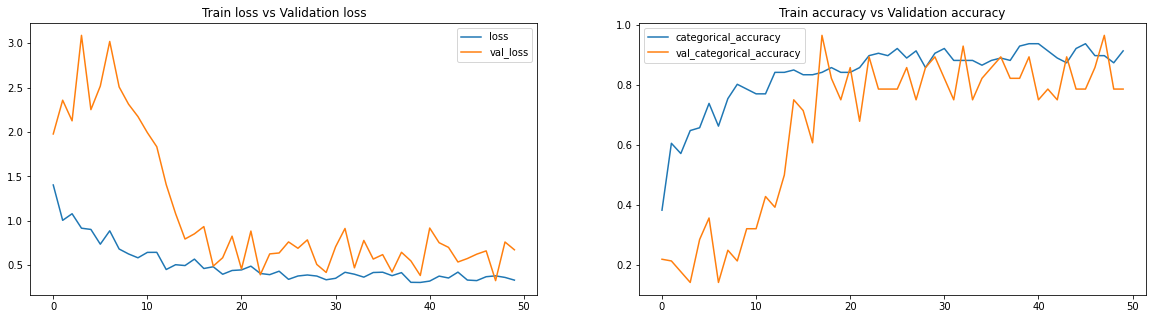

Max. Training Accuracy 0.937
Max. Validaiton Accuracy 0.964


In [17]:
plot_performance(history)

**Observations**
- Experimented with few modifications to architecture and model hyper parameters
    - n/w architecture
        - 3x TimeDistributed(Conv2D+BN+Pooling) + 1GRU + 2FC
        - 3x TimeDistributed(2xConv2D+BN+pooling) + 1GRU +2FC
    - number of frames considered - 10/15/18
    - Batch_size - 16/32/64
    - GRU units 64/128/256
- Deeper/larger network and larger bach_size resulted in out-of-memory issue   
- epochs - 20/30/50
    - fiter_size - (3,3,3)/(5,5,5)
    - LR - 0.001/0.0005
    - Optimizer ADAM/SGD
- Plan model was overfitting and introducing dropout layers reduced overfitting
- By reducing the inital LR to 0.0001 the noise in the validation loss over the epochs reduced 
- ADAM performed better rhan SGD
- Difficult to conclude if the CNN+RNN is better compared to 3DCNN, as we need to take average performance of the model over several runs

### CNN(basic CNN)+LSTM Model

In [19]:
## CNN + LSTM

filters = [16, 32, 64, 128]
kernel_size = [(2, 2), (3,3), (5, 5), (7,7)]
num_frames = 15
input_shape = (num_frames, h, w, num_ch)

lstm_model = Sequential()
lstm_model.add(TimeDistributed(Conv2D(filters[1], kernel_size=kernel_size[2], padding='same', activation='relu'),
                          input_shape=input_shape))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

lstm_model.add(TimeDistributed(Conv2D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu')))
lstm_model.add(TimeDistributed(Conv2D(filters[2], kernel_size=kernel_size[2], padding='same', activation='relu')))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

lstm_model.add(TimeDistributed(Conv2D(filters[3], kernel_size=kernel_size[2], padding='same', activation='relu')))
lstm_model.add(TimeDistributed(Conv2D(filters[3], kernel_size=kernel_size[2], padding='same', activation='relu')))
lstm_model.add(TimeDistributed(BatchNormalization()))
lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))


lstm_model.add(TimeDistributed(Flatten()))
lstm_model.add(LSTM(128))
# rnn_model.add(Dropout(0.2))

lstm_model.add(Dense(512, activation='relu'))
# lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(num_cls, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0001)
lstm_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 15, 120, 120, 32)  2432      
_________________________________________________________________
time_distributed_25 (TimeDis (None, 15, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 15, 60, 60, 64)    51264     
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 60, 60, 64)    102464    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 30, 30, 64)   

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
%%time
## Training
num_epochs = 50
history = lstm_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
42/42 [==============================] - 8s 125ms/step - loss: 1.5622 - categorical_accuracy: 0.3492 - val_loss: 1.6542 - val_categorical_accuracy: 0.2143

Epoch 00001: val_loss did not improve from 1.00805
Epoch 2/50
42/42 [==============================] - 5s 112ms/step - loss: 1.3795 - categorical_accuracy: 0.5079 - val_loss: 1.7707 - val_categorical_accuracy: 0.2143

Epoch 00002: val_loss did not improve from 1.00805
Epoch 3/50
42/42 [==============================] - 5s 113ms/step - loss: 1.3426 - categorical_accuracy: 0.4683 - val_loss: 1.6582 - val_categorical_accuracy: 0.2143

Epoch 00003: val_loss did not improve from 1.00805
Epoch 4/50
42/42 [==============================] - 5s 118ms/step - loss: 1.2525 - categorical_accuracy: 0.5000 - val_loss: 1.5201 - val_categorical_accuracy: 0.3214

Epoch 00004: val_loss did not improve from 1.00805
Epoch 5/50
42/42 [==============================] - 5s 111ms/step - loss: 1.0475 - categorical_accuracy: 0.6587 - val_loss: 1.65

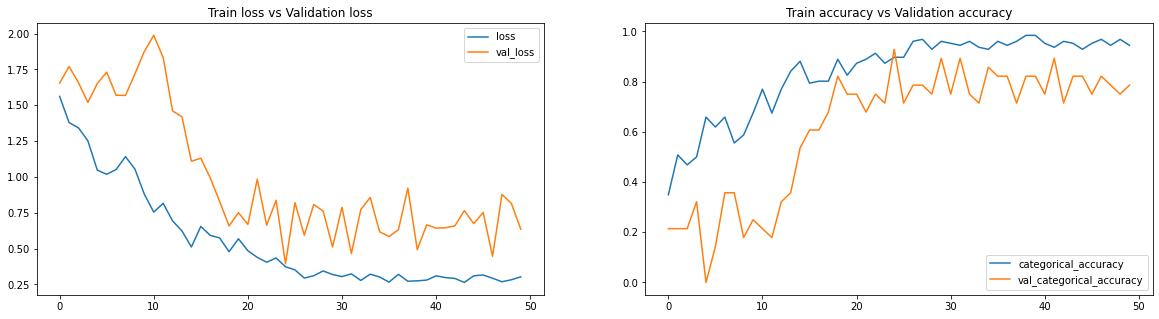

Max. Training Accuracy 0.984
Max. Validaiton Accuracy 0.929


In [21]:
plot_performance(history)

**Observations**
- Experimented with few modifications to architecture and model hyper parameters
    - n/w architecture
        - 3x TimeDistributed(Conv2D+BN+Pooling) + 1LSTM + 2FC
        - 3x TimeDistributed(2xConv2D+BN+pooling) + 1LSTM +2FC
    - number of frames considered - 10/15/18
    - Batch_size - 16/32/64
    - LSTM units 64/128/256
- Deeper/larger network and larger bach_size resulted in out-of-memory issue   
- epochs - 20/30/50
    - fiter_size - (3,3,3)/(5,5,5)
    - LR - 0.001/0.0005
    - Optimizer ADAM/SGD
- By reducing the initial learning rate the noise in the validation loss over the epochs reduced
- ADAM optimizer worked better than SGD
- Difficult to conclude if the CNN+RNN  or CNN+LSTM is better and also when compared to 3DCNN, as we need to take average performance of the model over several runs

### Pre-trained CNN(InceptionV3)+GRU Model

#### Inception-v3+GRU(64) Model + without dropout

In [12]:
## loading inception-v3 model and freezing all layers but last 10

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in inception.layers[:-10]:
    layer.trainabler = False

In [23]:
## Inception-V3 + GRU

cnn = Sequential([inception])
cnn.add(Conv2D(32,kernel_size=(3,3), padding='same'))
cnn.add(Flatten())
inc_gru = Sequential()
inc_gru.add(TimeDistributed(cnn, input_shape=(num_frames,h,w,num_ch)))
inc_gru.add(GRU(64, input_shape=(None,num_frames, cnn.layers[-1].output_shape[1]), return_sequences=False))
# inc_gru.add(LSTM(16))
inc_gru.add(Dropout(0.5))
inc_gru.add(Dense(5,activation='softmax'))

In [24]:
inc_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 128)           22392640  
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 22,430,213
Trainable params: 22,395,781
Non-trainable params: 34,432
_________________________________________________________________


In [25]:
%%time

## Compile the model
optimiser = optimizers.Adam()
inc_lsmt.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


## Model Training
num_epochs = 30
history = inc_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/train ; batch size = 16
Epoch 1/30
42/42 [==============================] - 62s 1s/step - loss: 0.8992 - categorical_accuracy: 0.6697 - val_loss: 2.0094 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 2.00940, saving model to model_init_2022-07-1211_58_33.092045\model-00001-0.89921-0.66968-2.00940-0.24000.h5
Epoch 2/30
42/42 [==============================] - 11s 258ms/step - loss: 1.2974 - categorical_accuracy: 0.5714 - val_loss: 1.9985 - val_categorical_accuracy: 0.2143

Epoch 00002: val_loss improved from 2.00940 to 1.99849, saving model to model_init_2022-07-1211_58_33.092045\model-00002-1.29743-0.57143-1.99849-0.21429.h5
Epoch 3/30
42/42 [==============================] - 11s 262ms/step - loss: 1.5941 - categorical_accuracy: 0.4048 - val_loss: 1.7505 - val_categorical_accuracy: 0.1786

Epoch 00003: val_loss improved from 1.99849 to 1.75049, saving model to model_ini

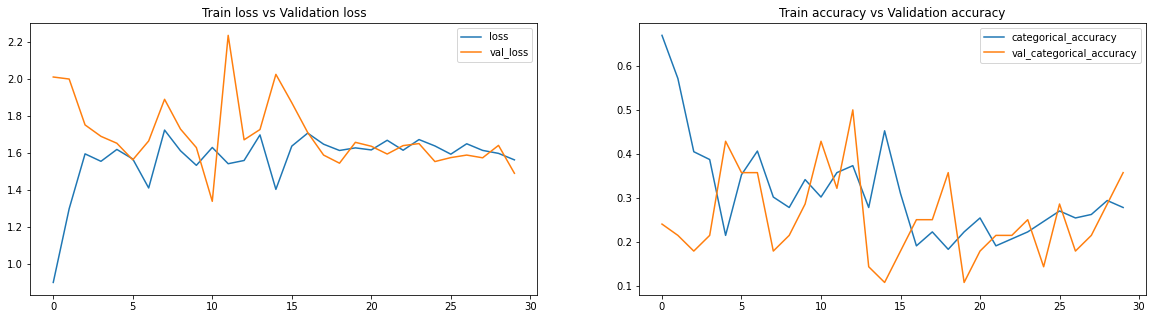

Max. Training Accuracy 0.67
Max. Validaiton Accuracy 0.5


In [26]:
plot_performance(history)

#### Inception-v3+GRU(128) Model + without dropout

In [57]:
### loading inception model and combining wiht GRU

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in inception.layers[:-10]:
    layer.trainabler = False

cnn = Sequential([inception])
cnn.add(Conv2D(32,kernel_size=(3,3), padding='same'))
cnn.add(Flatten())
inc_gru = Sequential()
inc_gru.add(TimeDistributed(cnn, input_shape=(num_frames,h,w,num_ch)))
inc_gru.add(GRU(128, input_shape=(None,num_frames, cnn.layers[-1].output_shape[1]), return_sequences=False))
# inc_gru.add(Dropout(0.5))
inc_gru.add(Dense(5,activation='softmax'))

inc_gru.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 15, 128)           22392640  
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 645       
Total params: 22,492,357
Trainable params: 22,457,925
Non-trainable params: 34,432
_________________________________________________________________


In [58]:
%%time

optimiser = optimizers.Adam()
inc_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



num_epochs = 30
history = inc_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - 19s 199ms/step - loss: 1.9528 - categorical_accuracy: 0.2381 - val_loss: 1.6317 - val_categorical_accuracy: 0.2857

Epoch 00001: val_loss did not improve from 1.34203
Epoch 2/30
42/42 [==============================] - 6s 144ms/step - loss: 1.6183 - categorical_accuracy: 0.2222 - val_loss: 1.6353 - val_categorical_accuracy: 0.2143

Epoch 00002: val_loss did not improve from 1.34203
Epoch 3/30
42/42 [==============================] - 6s 142ms/step - loss: 1.5562 - categorical_accuracy: 0.2778 - val_loss: 1.7045 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 1.34203
Epoch 4/30
42/42 [==============================] - 6s 142ms/step - loss: 1.5076 - categorical_accuracy: 0.3333 - val_loss: 1.6641 - val_categorical_accuracy: 0.1786

Epoch 00004: val_loss did not improve from 1.34203
Epoch 5/30
42/42 [==============================] - 6s 144ms/step - loss: 1.4753 - categorical_accuracy: 0.3889 - val_loss: 1.7

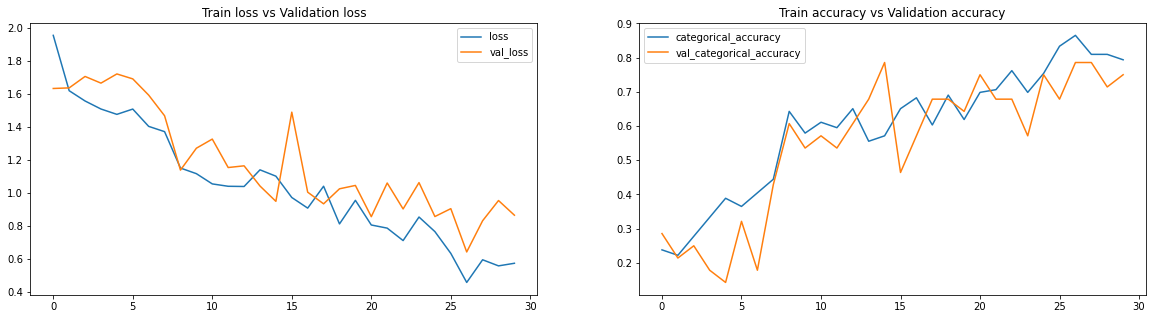

Max. Training Accuracy 0.865
Max. Validaiton Accuracy 0.786


In [59]:
plot_performance(history)

#### Inception-v3+GRU(128) Model + without dropout + LR =0.0001

In [25]:
### loading inception model and combining wiht GRU

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in inception.layers[:-10]:
    layer.trainabler = False

cnn = Sequential([inception])
cnn.add(Conv2D(32,kernel_size=(3,3), padding='same'))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
inc_gru = Sequential()
inc_gru.add(TimeDistributed(cnn, input_shape=(num_frames,h,w,num_ch)))
inc_gru.add(GRU(128, input_shape=(None,num_frames, cnn.layers[-1].output_shape[1]), return_sequences=False))
inc_gru.add(Dropout(0.5))
inc_gru.add(Dense(5,activation='softmax'))

inc_gru.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 15, 128)           22392640  
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 22,492,357
Trainable params: 22,457,925
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
%%time

optimiser = optimizers.Adam(learning_rate=0.0001)
inc_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



num_epochs = 30
history = inc_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - 19s 196ms/step - loss: 1.8689 - categorical_accuracy: 0.2143 - val_loss: 1.5274 - val_categorical_accuracy: 0.1786

Epoch 00001: val_loss did not improve from 0.14471
Epoch 2/30
42/42 [==============================] - 6s 139ms/step - loss: 1.6891 - categorical_accuracy: 0.2857 - val_loss: 1.4555 - val_categorical_accuracy: 0.4286

Epoch 00002: val_loss did not improve from 0.14471
Epoch 3/30
42/42 [==============================] - 6s 141ms/step - loss: 1.4925 - categorical_accuracy: 0.2937 - val_loss: 1.7405 - val_categorical_accuracy: 0.4286

Epoch 00003: val_loss did not improve from 0.14471
Epoch 4/30
42/42 [==============================] - 6s 136ms/step - loss: 1.2993 - categorical_accuracy: 0.4524 - val_loss: 1.1107 - val_categorical_accuracy: 0.6786

Epoch 00004: val_loss did not improve from 0.14471
Epoch 5/30
42/42 [==============================] - 6s 143ms/step - loss: 1.2026 - categorical_accuracy: 0.5397 - val_loss: 1.0

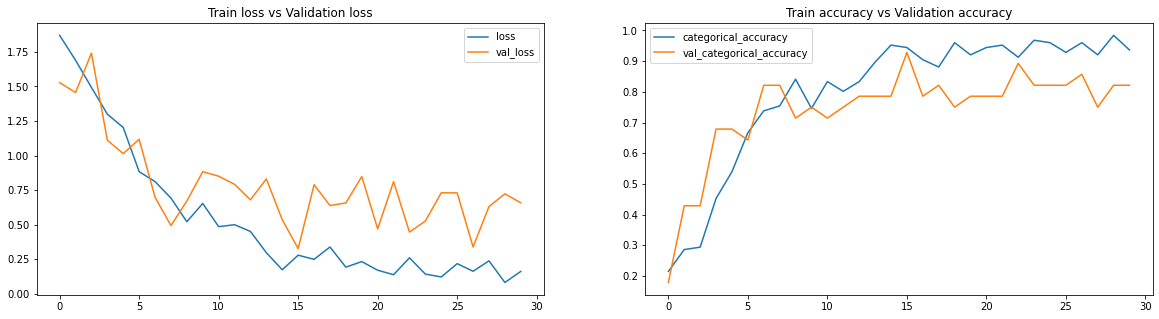

Max. Training Accuracy 0.984
Max. Validaiton Accuracy 0.929


In [27]:
plot_performance(history)

### Pretrained (InceptionV3) + LSTM

#### Inception-v3+LSTM Model + without dropout + LR = 0.0001

In [31]:
### loading inception model and combining wiht LSTM

inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in inception.layers[:-10]:
    layer.trainabler = False

cnn = Sequential([inception])
cnn.add(Conv2D(32,kernel_size=(3,3), padding='same'))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
inc_lstm = Sequential()
inc_lstm.add(TimeDistributed(cnn, input_shape=(num_frames,h,w,num_ch)))
inc_lstm.add(LSTM(128, input_shape=(None,num_frames, cnn.layers[-1].output_shape[1]), return_sequences=False))
# inc_lstm.add(Dropout(0.5))
inc_lstm.add(Dense(5,activation='softmax'))

inc_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 128)           22392640  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 22,524,869
Trainable params: 22,490,437
Non-trainable params: 34,432
_________________________________________________________________


In [32]:
%%time

optimiser = optimizers.Adam(learning_rate=0.0001)
inc_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



num_epochs = 30
history = inc_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\dhana\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
42/42 [==============================] - 18s 193ms/step - loss: 1.6269 - categorical_accuracy: 0.2778 - val_loss: 1.5732 - val_categorical_accuracy: 0.2857

Epoch 00001: val_loss did not improve from 0.14471
Epoch 2/30
42/42 [==============================] - 6s 141ms/step - loss: 1.4067 - categorical_accuracy: 0.4841 - val_loss: 1.4980 - val_categorical_accuracy: 0.3929

Epoch 00002: val_loss did not improve from 0.14471
Epoch 3/30
42/42 [==============================] - 6s 140ms/step - loss: 1.2688 - categorical_accuracy: 0.5238 - val_loss: 0.9043 - val_categorical_accuracy: 0.6429

Epoch 00003: val_loss did not improve from 0.14471
Epoch 4/30
42/42 [==============================] - 6s 145ms/step - loss: 0.9698 - categorical_accuracy: 0.6270 - val_loss: 0.9251 - val_categorical_accuracy: 0.6786

Epoch 00004: val_loss did not improve from 0.14471
Epoch 5/30
42/42 [==============================] - 6s 141ms/step - loss: 0.6710 - categorical_accuracy: 0.7778 - val_loss: 0.4

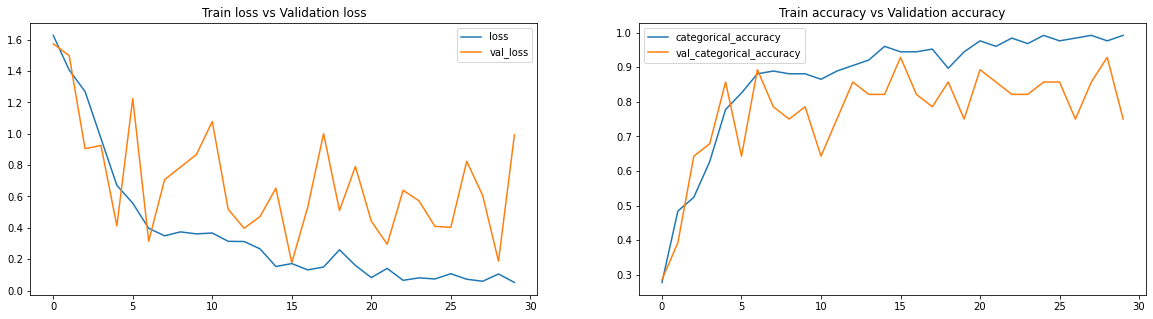

Max. Training Accuracy 0.992
Max. Validaiton Accuracy 0.929


In [33]:
plot_performance(history)

#### Inception-v3+LSTM Model + with dropout (0.4) + LR = 0.0001

In [37]:
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(120, 120, 3))
for layer in inception.layers[:-10]:
    layer.trainabler = False

cnn = Sequential([inception])
cnn.add(Conv2D(32,kernel_size=(3,3), padding='same'))
# cnn.add(Dropout(0.2))
cnn.add(Flatten())
inc_lstm = Sequential()
inc_lstm.add(TimeDistributed(cnn, input_shape=(num_frames,h,w,num_ch)))
inc_lstm.add(LSTM(128, input_shape=(None,num_frames, cnn.layers[-1].output_shape[1]), return_sequences=False))
inc_lstm.add(Dropout(0.4))
inc_lstm.add(Dense(5,activation='softmax'))

inc_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 15, 128)           22392640  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 22,524,869
Trainable params: 22,490,437
Non-trainable params: 34,432
_________________________________________________________________


In [38]:
%%time

optimiser = optimizers.Adam(learning_rate=0.0001)
inc_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])



num_epochs = 30
history = inc_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
42/42 [==============================] - 17s 200ms/step - loss: 1.6732 - categorical_accuracy: 0.2063 - val_loss: 1.4559 - val_categorical_accuracy: 0.4286

Epoch 00001: val_loss did not improve from 0.14471
Epoch 2/30
42/42 [==============================] - 6s 142ms/step - loss: 1.5360 - categorical_accuracy: 0.3492 - val_loss: 1.5765 - val_categorical_accuracy: 0.3214

Epoch 00002: val_loss did not improve from 0.14471
Epoch 3/30
42/42 [==============================] - 6s 145ms/step - loss: 1.3198 - categorical_accuracy: 0.4841 - val_loss: 1.2080 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.14471
Epoch 4/30
42/42 [==============================] - 6s 135ms/step - loss: 0.8542 - categorical_accuracy: 0.7460 - val_loss: 0.9402 - val_categorical_accuracy: 0.6786

Epoch 00004: val_loss did not improve from 0.14471
Epoch 5/30
42/42 [==============================] - 6s 143ms/step - loss: 0.7674 - categorical_accuracy: 0.7063 - val_loss: 0.7

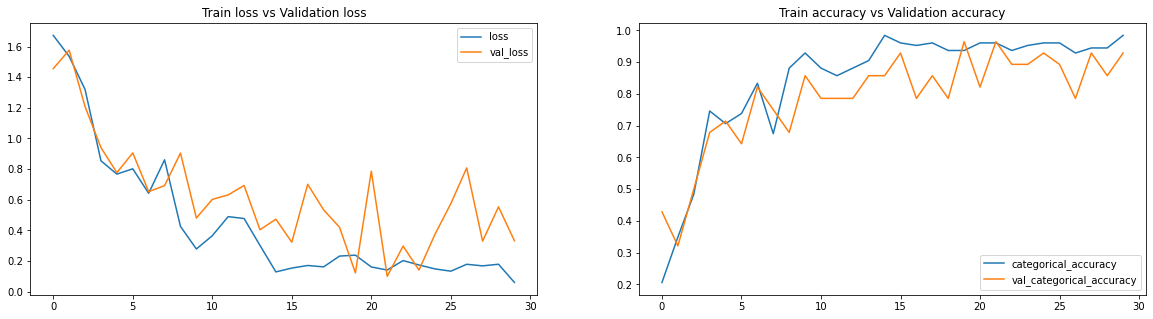

Max. Training Accuracy 0.984
Max. Validaiton Accuracy 0.964


In [39]:
plot_performance(history)

## Conculstion

- Three types of models tested
    - 3D convolution
    - SimpleCNN with GRU/LSTM
    - Pretrained CNN with GRU/LSTM
- with limited experimentation as conducted above it is difficult to determine which model is best compared to other
- All 3 types of modeling has produced val accuracy > 0.9 
- requires to run more experimentations and averaging the performance over multiple runs for particular model configuration
- CNN+LSTM performed better without regularization layer, where as CNN+GRU overfits and needed regularization 
- The GPU used for training is RTX2070 max-Q, large models could not be trained, often faced OMM(out of Memory) issue, hence have to reduce the model complexity

## Verifying the final.h5 saved model

In [41]:
## loading the saved model
saved_model = tf.keras.models.load_model('final.h5')
saved_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 15, 128)           22392640  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 22,524,869
Trainable params: 22,490,437
Non-trainable params: 34,432
_________________________________________________________________


In [43]:
## creating generator object
sample_generator = generator(val_path, val_doc, batch_size)

## creating sample validation data
sample_data, sample_label = next(sample_generator)
print(sample_data.shape, sample_label.shape)

Source path =  D:/MS_Upgrad/05_Deep_Learning/Project_Gesture_Recognition/Project_data/val ; batch size = 16
(16, 15, 120, 120, 3) (16, 5)


In [60]:
sample_label

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [46]:
## making prediction on sample data
pred = saved_model.predict(sample_data)
pred.shape

(16, 5)

In [58]:
## creating multi-class output
y_pred = tf.one_hot(tf.argmax(pred, axis=1), pred.shape[1])
y_pred

<tf.Tensor: shape=(16, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>